In [4]:
import xarray as xr
import pandas as pd
import numpy as np
import yaml
from interpolation import VerticalGrid

In [36]:
# filepaths
geos_chem_ch4_filepath = "data/GEOSChem.SpeciesConc.20190822_0000z.nc4"
geos_chem_level_edges_filepath = "data/GEOSChem.LevelEdgeDiags.20190822_0000z.nc4"
gosat_file_path = (
    "data/UoL-GHG-L2-CH4-GOSAT-OCPR-20190822-fv9.0.nc"
)
# load config file
with open("config.yaml", "r", encoding="utf8") as f:
    config = yaml.safe_load(f)

In [27]:
model_fields = config["MODEL"]
sat_fields = config["GOSATv9_0"]["DATA_FIELDS"]

def read_GOSATv9_0(file_path):
    fields = sat_fields
    gosat = xr.open_dataset(file_path)
    [
        [
            fields["LATITUDE"],
            fields["LONGITUDE"],
            fields["PRESSURE_EDGES"],
            fields["TIME"],
            fields["PRESSURE_WEIGHT"],
            fields["AVERAGING_KERNEL"],
            fields["PRIOR_PROFILE"],
            fields["SATELLITE_COLUMN"],
            fields["QUALITY_FLAG"],
        ]
    ]
    gosat = gosat.where(gosat[fields["QUALITY_FLAG"]] == 0, drop=True)
    gosat = gosat.where(
        np.all(gosat["pressure_levels"] > 0, axis=1), drop=True
    )  # (todo: don't need to skip these... fix)
    return gosat


def colocate_gridcells(model, satellite):
    """
    directly from Hannah's code
    get gridcells which are coincident with each satellite observation
    assumes model pixel size >> satellite pixel size
    fast implementation, credit Nick
    """
    # Find the grid box and time indices corresponding to TROPOMI obs
    fields = sat_fields
    # i index
    iGC = np.abs(
        model.lon.values.reshape((-1, 1))
        - satellite[fields["LATITUDE"]].values.reshape((1, -1))
    )
    iGC = iGC.argmin(axis=0)

    # j index
    jGC = np.abs(
        model.lat.values.reshape((-1, 1))
        - satellite[fields["LONGITUDE"]].values.reshape((1, -1))
    )
    jGC = jGC.argmin(axis=0)

    # Time index
    tGC = np.where(satellite[fields["TIME"]].dt.hour == model.time.dt.hour)[1]

    return iGC, jGC, tGC


def get_model_columns(
    model_ch4,
    model_edges,
    sat,
    centers_or_edges,
):
    """
    generic function to apply an operator to a satellite
    takes:
        - GEOS-Chem dataframe (not a problem b/c this is standard)
        - all required satellite inputs as np arrays
    """
    # for nobs observations at one time:
    iGC, jGC, tGC = colocate_gridcells(model_ch4, sat)
    model_on_sat_levels = (
        VerticalGrid(
            model_conc_at_layers=model_ch4[
                model_fields["CONCENTRATION_AT_PRESSURE_CENTERS"]
            ]
            .transpose("time", "lon", "lat", "lev")
            .values[tGC, iGC, jGC, :],
            model_edges=model_edges[model_fields["PRESSURE_EDGES"]]
            .transpose("time", "lon", "lat", "ilev")
            .values[tGC, iGC, jGC, :],
            satellite_edges=sat[sat_fields["PRESSURE_EDGES"]],
            interpolate_to_centers_or_edges=centers_or_edges,
        ).interpolate()
        * 1e9
    )

    sat_prior = sat[sat_fields["PRIOR_PROFILE"]]
    sat_avker = sat[sat_fields["AVERAGING_KERNEL"]]
    sat_pressure_weight = sat[sat_fields["PRESSURE_WEIGHT"]]

    model_column = np.sum(
        sat_pressure_weight
        * (sat_prior + sat_avker * (model_on_sat_levels - sat_prior)),
        axis=1,
    )
    sat_column = sat[sat_fields["SATELLITE_COLUMN"]]

    return model_column, sat_column

In [28]:
# read files
model_ch4 = xr.open_dataset(geos_chem_ch4_filepath)
model_edges = xr.open_dataset(geos_chem_level_edges_filepath)
gosat = read_GOSATv9_0(gosat_file_path)

In [29]:
# run column operator
model_columns, sat_columns = get_model_columns(
    model_ch4, 
    model_edges,
    gosat, 
    centers_or_edges = "edges"
)

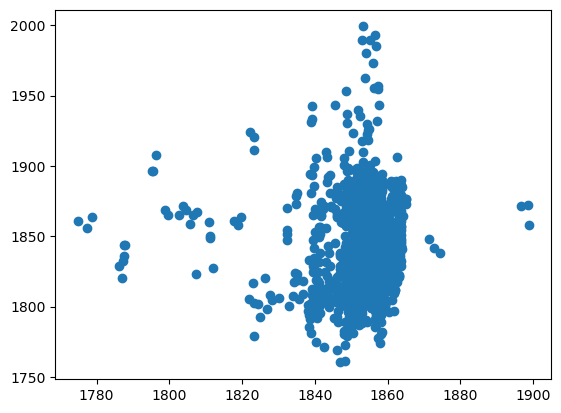

In [35]:
import matplotlib.pyplot as plt

plt.scatter(model_columns, sat_columns)